# Superellipsoid Sampling

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
#%matplotlib

NUM_SAMPLES=10000

## Sampling using Parametric Representation

Visualizations are not good **even though I have sampled 10000 points**.

In [2]:
def c_func(w,m):
    return np.sign(np.cos(w)) * np.abs(np.cos(w))**m

def s_func(w,m):
    return np.sign(np.sin(w)) * np.abs(np.sin(w))**m

# superellipsoid -> x,y,z : https://en.wikipedia.org/wiki/Superellipsoid
def superellipsoid_to_xyz(A=1,B=1,C=1,E1=0.5,E2=0.3):
    v = np.linspace(-np.pi/2, np.pi/2, np.int32(np.sqrt(NUM_SAMPLES)))
    u = np.linspace(-np.pi, np.pi, np.int32(np.sqrt(NUM_SAMPLES)))
    uu, vv = np.meshgrid(u,v)
    r = 2/E2
    t = 2/E1
    x = A * c_func(vv, 2/t) * c_func(uu, 2/r)
    y = B * c_func(vv, 2/t) * s_func(uu, 2/r)
    z = C * s_func(vv, 2/t)
    return x,y,z

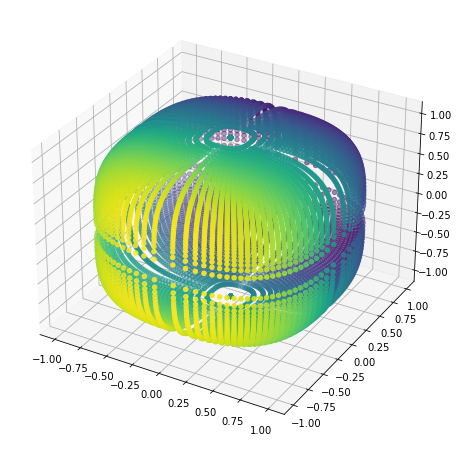

In [3]:
a=1
b=1
c=1
e1=0.5
e2=0.7

x,y,z = superellipsoid_to_xyz(a,b,c,e1,e2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')              
_=ax.scatter(x, y, z, c=-y)

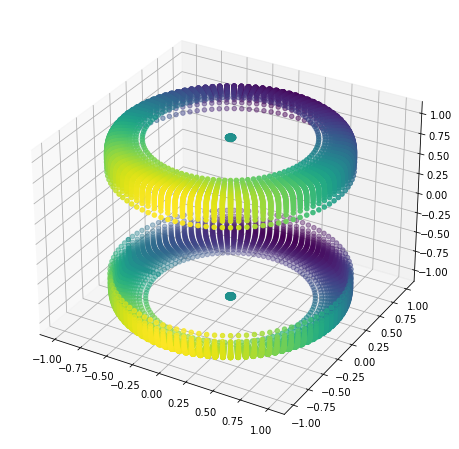

In [4]:
a=1
b=1
c=1
e1=0.1
e2=1

x,y,z = superellipsoid_to_xyz(a,b,c,e1,e2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')              
_=ax.scatter(x, y, z, c=-y)

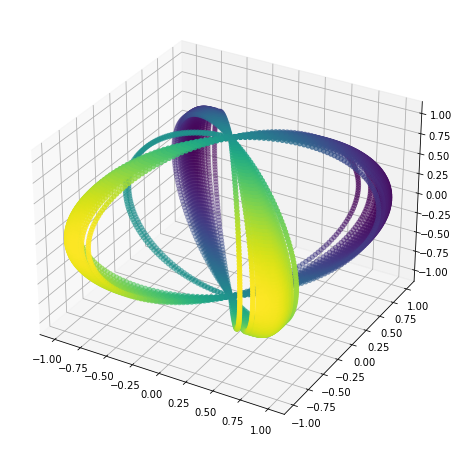

In [5]:
a=1
b=1
c=1
e1=1
e2=0.1

x,y,z = superellipsoid_to_xyz(a,b,c,e1,e2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')              
_=ax.scatter(x, y, z, c=-y)

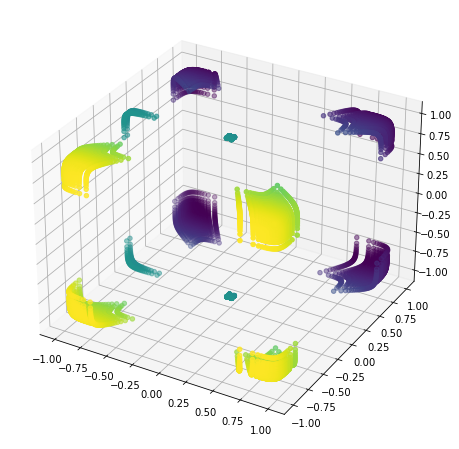

In [6]:
a=1
b=1
c=1
e1=0.1
e2=0.1

x,y,z = superellipsoid_to_xyz(a,b,c,e1,e2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')              
_=ax.scatter(x, y, z, c=-y)

## Sampling Superquadric Point Clouds with Normals

It didn't work / I couldn't do it.

Paper: https://arxiv.org/pdf/1802.05176.pdf

In [7]:
def sample_se(a,b,e,D):
    arr = [0.]
    N=0
    while arr[N] < np.pi/2:
        next_item = update_theta(arr[N], a, b, e, D)
        N+=1
        arr.append(next_item.real)
    N+=1
    arr.append(np.pi/2)
    while arr[N] > 0:
        next_item = update_theta(arr[N], a, b, e, D)
        N+=1
        arr.append(next_item.real)
    
    return np.array(arr)

def update_theta(theta, a, b, e, D):
    theta_eps = 0.01
    
    if theta <= theta_eps:
        delta_theta = (D/b - theta**e)**(1/e) - theta
    else:
        if np.pi/2 - theta <= theta_eps:
            theta_n = (D/a - (np.pi/2 - theta)**e)**(1/e) - (np.pi - theta)
        else:
            theta_n = (D/e) * np.cos(theta) * np.sin(theta)
            theta_n = theta_n / (a**2 * np.cos(theta)**(2*e) * np.sin(theta)**4 + b**2 * np.sin(theta)**(2*e) * np.cos(theta)**4)
        delta_theta = theta_n
    return theta + delta_theta

def superellipsoid(a,b,c,e1,e2,D):
    H = sample_se(1.,c,e1,D)
    omg = sample_se(a,b,e2,D)
    N_omg = len(omg)
    X = []
    Y = []
    Z = []
    for i in [-1,1]:
        for j in [-1,1]:
            for k in [-1,1]:
                cos_omg = np.cos(j*omg)
                sin_omg = np.sin(j*omg)
                cos_H = np.cos(k*H)
                sin_H = np.sin(k*H)
                X += list(i * a * cos_omg**e2 * cos_H**e1)
                Y += list(i * b * sin_omg**e2 * cos_H**e1)
                Z += list(i * c * 1 * sin_H) # ???
    return np.array(X), np.array(Y), np.array(Z)

In [8]:
#X,Y,Z = superellipsoid(0.7, 0.7, 0.7, 0.5, 0.5, 100)
#fig = plt.figure()
#ax = plt.axes(projection='3d')
#ax.scatter(X, Y, Z)

## Projecting Fibonacci Sphere onto Superellipsoid (my solution)

I couldn't make the previous method run so this is **my solution** for sampling problem. The idea is projecting fibonacci sphere onto the superellipsoid surface with minimum required iterations. Since there are no closed-form solutions for computing distance between point and superellipsoid, approximations are being used. According to my observations, while Solina’s estimation [2] works better inside of superellipsoid, radial Euclidean distance [1] works better outside of superellipsoid. The idea is projecting points onto the surface iteratively for better results. I found 10 iterations are enough for the given $e_1$ and $e_2$ values.

Also, I found projecting fibonacci sphere onto **unit** superellipsoid and scaling it (using a,b,c) afterward works better. I have observed some artifacts with lower $e_1$ and $e_2$ values. Furthermore, to achieve stable results I recommend limiting $e_1$ and $e_2$ values between `0.01` and `2.0` (found empirically for 1000 samples).

Drawbacks of this method are:

- Points look uniformly-sampled-like but before scaling with $a$,$b$,$c$. For example, $a=b=1$ and $c=1000$ may look pretty weird. This problem is not observed in visualizations below because matplotlib applies normalization on each axis.

**Reference:**

- [1] Eric BARDINET, Laurent D. COHEN, and Nicolas AYACHE. A parametric deformable model to fit unstructured 3D data. Research report 2617 - INRIA, 1995.
- [2] Franc SOLINA and Ruzena BAJCSY. Recovery of parametric models from range images: the case for superquadrics with global deformations. IEEE Transactions on Pattern Analysis and Machine Intelligence, 12(2):131–147, 1990.

In [19]:
def fibonacci_sphere(samples=1000):
    points = np.zeros((samples, 3))
    phi = np.pi * (3 - np.sqrt(5))  # golden angle in radians

    for i in range(samples):
        y = 1 - (i / (samples - 1)) * 2  # y goes from 1 to -1
        radius = np.sqrt(1 - y * y)  # radius at y

        theta = phi * i  # golden angle increment

        x = np.cos(theta) * radius
        z = np.sin(theta) * radius

        points[i] = [x, y, z]

    return points

def compute_distance(x,y,z,e1,e2): # assume a=b=c=1
    f = (np.abs(x)**(2/e2) + np.abs(y)**(2/e2) )**(e2/e1) + np.abs(z)**(2/e1)
    dist = np.abs(f**(e1/2)-1)
    return np.where(f>1, dist, -dist)

# for 1000 samples limit 0.01<=e1/e2<=1.0
def sample_superellipsoid(a, b, c, e1, e2, num_samples=NUM_SAMPLES, check_e1_e2=True):
    if check_e1_e2:
        e1 = np.clip(e1, 0.01, 2.0)
        e2 = np.clip(e2, 0.01, 2.0)
  
    points = fibonacci_sphere(num_samples)
    for i in range(10): 
        d = compute_distance(points[:,0],points[:,1],points[:,2],e1,e2) # signed dist to superellipsoid surface
        m = np.sum(points**2, axis=1)**0.5 # dist from center
        points = points * ((-d+m)/m).reshape(-1,1)
    points *= np.array([a,b,c])
    return points

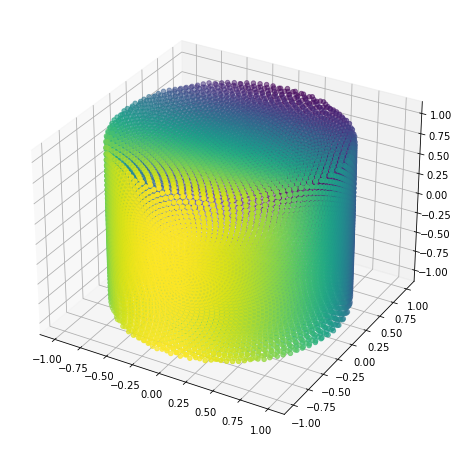

In [20]:
a=1
b=1
c=1
e1=0.01
e2=1

points = sample_superellipsoid(a,b,c,e1,e2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:, 2], c=-points[:, 1])

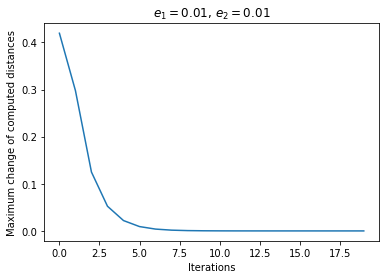

In [21]:
def sample_superellipsoid_debug_(a, b, c, e1, e2, num_samples=100000, max_iter = 20):
    points = fibonacci_sphere(num_samples)
    d_ = []
    for i in range(max_iter):
        d = compute_distance(points[:,0],points[:,1],points[:,2],e1,e2)
        m = np.sum(points**2, axis=1)**0.5
        d_.append(m)
        points = points * ((-d+m)/m).reshape(-1,1)
    points *= np.array([a,b,c])
    return points, np.array(d_)

e1,e2 = 0.01, 0.01
points, d = sample_superellipsoid_debug_(a,b,c,e1,e2)
dd = np.max(np.gradient(d, axis=0), axis=1)
plt.xlabel("Iterations")
plt.ylabel("Maximum change of computed distances")
plt.title("$e_1={}$, $e_2={}$".format(e1,e2))
_=plt.plot(dd)

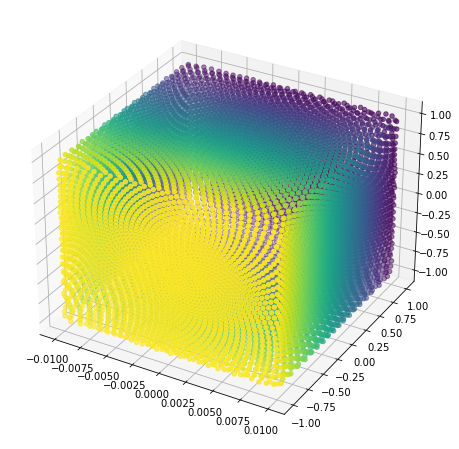

In [11]:
a=0.01
b=1
c=1
e1=0.01
e2=0.01

points = sample_superellipsoid(a,b,c,e1,e2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:, 2], c=-points[:, 1])

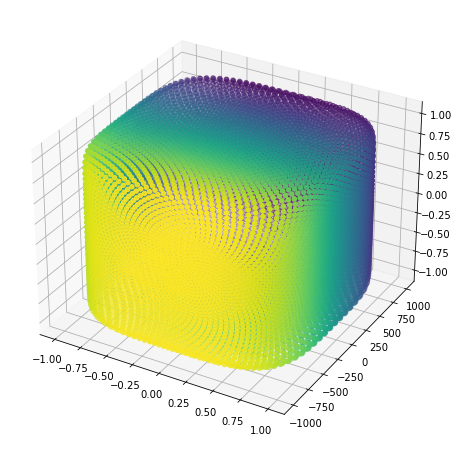

In [12]:
a=1
b=1000
c=1
e1=0.1
e2=0.5

points = sample_superellipsoid(a,b,c,e1,e2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:, 2], c=-points[:, 1])

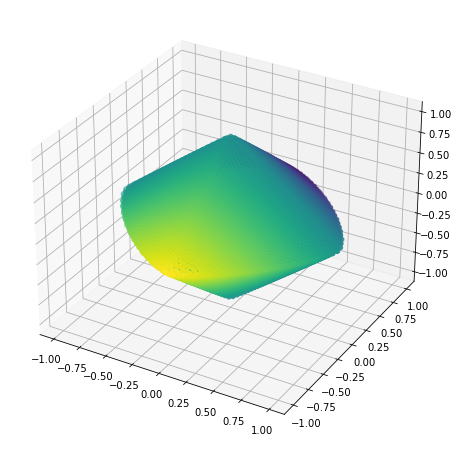

In [13]:
# NOT A SUPERELLIPSOID BUT STILL WORKS WELL...

a=1
b=1
c=1
e1=2
e2=1.5

points = sample_superellipsoid(a,b,c,e1,e2)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:, 2], c=-points[:, 1])

/tmp/ipykernel_44133/3055218822.py:19: RuntimeWarning: overflow encountered in power
  f = ((np.abs(x)/a)**(2/e2) + (np.abs(y)/b)**(2/e2) )**(e2/e1) + (np.abs(z)/c)**(2/e1)
/tmp/ipykernel_44133/3055218822.py:19: RuntimeWarning: overflow encountered in square
  f = ((np.abs(x)/a)**(2/e2) + (np.abs(y)/b)**(2/e2) )**(e2/e1) + (np.abs(z)/c)**(2/e1)
/tmp/ipykernel_44133/3055218822.py:34: RuntimeWarning: invalid value encountered in add
  points = points * ((-d+m)/m).reshape(-1,1)


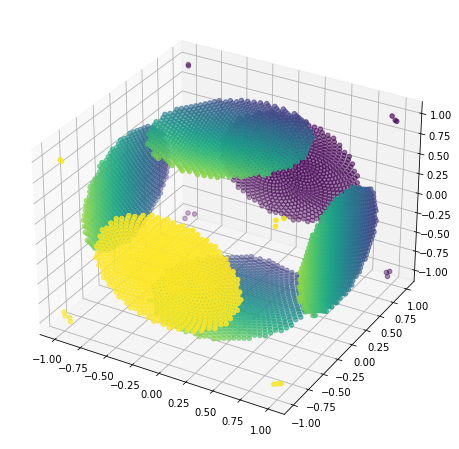

In [14]:
# VERY VERY LOW E1/E2 VALUES IMPACT THE STABILITY OF THIS METHOD

a=1
b=1
c=1
e1=0.0005
e2=0.001

points = sample_superellipsoid(a,b,c,e1,e2,check_e1_e2=False)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(points[:,0], points[:,1], points[:, 2], c=-points[:, 1])